# <center>TensorFlow и Keras для задач
## <center>Принципы работы библиотек для глубокого обучения
Рассмотрим модель из нескольких полносвязных (или любых других) слоёв:

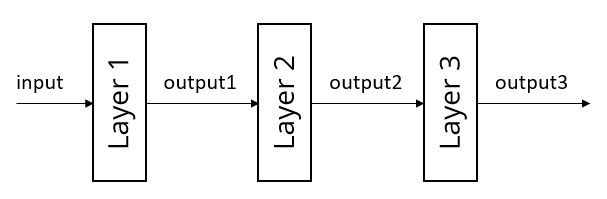

Чтобы воспользоваться алгоритмом обратного распространения ошибки, нам нужно запоминать выходы всех слоёв: output1, output2, output3. Если же мы делаем инференс, то после получения output2 можно удалить из памяти output1 — он нам больше не нужен. Аналогично, получив output3, удаляем output2.

Поэтому для обучения требуется существенно больше оперативной памяти, чем для инференса. За счёт этого при инференсе можно использовать больший размер батча.

В библиотеках TensorFlow и PyTorch веса и выходные данные каждого слоя сети хранятся не в NumPy-массивах, а в так называемых тензорах (объектах tf.Tensor, tf.EagerTensor, torch.Tensor).

**Основные отличия тензора от NumPy-массива в следующем:**

1. Тензоры, как правило, хранятся в памяти GPU или TPU.
2. История операций над тензорами (таких как сложение, умножение) запоминается таким образом, чтобы по графу вычислений можно было «пройти в обратную сторону» и рассчитать градиенты.

### СТАТИЧЕСКИЙ И ДИНАМИЧЕСКИЙ ГРАФ ВЫЧИСЛЕНИЙ
Существует два основных подхода к построению графов вычислений:

1. При **декларативном** (то есть описательном) подходе граф вычислений строится заранее, а затем по нему «пропускаются» данные.

    Выполняя операции над тензорами, мы не выполняем вычислений, а только строим граф (это напоминает построение трубопровода). Затем весь граф целиком мы запускаем одной командой. Граф вычислений при этом называется **статическим**.

2. При **императивном** подходе, выполняя операции над тензорами, мы сразу получаем результат. При этом граф вычислений не описывается заранее и называется **динамическим**.

|Граф|Плюсы|Минусы|
|-|-|-|
|Статический|Библиотека «заранее знает» порядок операций в графе. Это позволяет эффективно оптимизировать граф в плане скорости вычислений и потребляемой памяти.|Сложнее писать и отлаживать код по сравнению с динамическим графом вычислений.|
|Динамический|Код проще и интуитивно понятнее.|Библиотека «не знает», какую операцию вы выполните следующей, что затрудняет оптимизацию скорости вычислений и потребляемой памяти. Однако есть способ преодолеть эту проблему путём анализа исходного кода модели и JIT-компиляции.|

В **PyTorch** используется динамический граф вычислений.

В **TensorFlow** версии 2 граф вычислений можно строить как динамически (*eager mode*), так и статически (*graph mode*).

В **Keras** граф вычислений преимущественно статический, однако при желании можно переключить его в динамический режим (*eager mode*).

В целом разработчики *TensorFlow* придерживаются точки зрения о том, что по возможности лучше использовать статический граф вычислений для повышения производительности.

## <center>Построение моделей в Keras

```py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers
import numpy as np
```

Для создания моделей в Keras есть два основных класса: **Sequential** и **Model**.

>Класс **Sequential** является подклассом **Model** и описывает модель, состоящую из цепочки слоёв, выполняющихся **последовательно**.

Например, так мы создадим модель c двумя скрытыми слоями по 100 нейронов и функцией активации ReLU и выходным слоем из 10 нейронов с функцией активации softmax:

```py
model = Sequential([
    layers.InputLayer(input_shape=(50,)),
    layers.Dense(100, 'relu'),
    layers.Dense(100, 'relu'),
    layers.Dense(10, 'softmax')
])
```

В модель `Sequential` можно добавлять новые слои методом `.add()`, но в таком действии редко бывает необходимость. Удобнее сразу передавать в конструктор `Sequential` все слои в виде списка.

Слой `InputLayer` не выполняет вычислений и лишь указывает размер входных данных сети. Мы можем убрать этот слой и вместо этого указать параметр `input_shape` у первого полносвязного слоя:

```py
model = Sequential([
    layers.Dense(100, 'relu', input_shape=(50,)),
    layers.Dense(100, 'relu'),
    layers.Dense(10, 'softmax')
])
```

Слои модели хранятся в виде списка в атрибуте `.layers`. Напечатать структуру модели можно, вызвав метод `.summary()`:

```py
model.summary()
```

Любую модель можно вызвать как функцию, передав в качестве параметра батч входных данных и получив батч выходных данных в виде тензора. Тензор затем можно преобразовать в NumPy-массив методом .numpy():

```py
batch_size = 64
input_batch = np.zeros((batch_size, 50))
output = model(input_batch).numpy() 
#получаем массив размером (64, 10)
```

Если некий *Python*-объект вызывается как функция, то для этого объекта неявно вызывается метод `.__call__()`.

При вызове модели как функции можно передать дополнительный параметр training=True, который означает запуск модели в режиме обучения (например, будет работать слой Dropout). По умолчанию модель запускается в режиме инференса.

```py
model = Sequential([
    layers.Dropout(0.999)
])
 
print(model(np.ones((1, 5))).numpy())
print(model(np.ones((1, 5)), training=True).numpy())

[[1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0.]]
```

`Dropout` случайным образом зануляет указанную долю значений в тензоре, передаваемом через этот слой. Этот слой работает в режиме обучения и не работает в режиме инференса.

При создании модели мы можем вообще не указывать размер входных данных (ни с помощью `InputLayer`, ни с помощью `input_shape` первого слоя). В этом случае размер входных данных будет рассчитан автоматически при первом вызове модели. В этот же момент будут созданы веса слоёв. Если попытаться получить `summary` по модели до того, как созданы веса слоёв, то будет выброшено исключение: `This model has not yet been built`.



In [1]:
import tensorflow as tf
import keras

In [3]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(400,)),
    keras.layers.Dense(300),
    keras.layers.Dense(200),
    keras.layers.Dense(100),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               120300    
                                                                 
 dense_4 (Dense)             (None, 200)               60200     
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
Total params: 200600 (783.59 KB)
Trainable params: 200600 (783.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### ПОСТРОЕНИЕ МОДЕЛИ В ФУНКЦИОНАЛЬНОМ СТИЛЕ

Построение модели через конструктор класса `Model` — более общий способ, позволяющий строить разветвлённые графы вычислений.

Модель, аналогичная той, что мы строили выше, в функциональном стиле строится так:

```Python
input_layer = keras.Input(shape=(50,))
output1 = layers.Dense(100, 'relu')(input_layer)
output2 = layers.Dense(100, 'relu')(output1)
output3 = layers.Dense(10, 'softmax')(output2)
model = Model(inputs=input_layer, outputs=output3)
```

На этом примере хорошо видно, что мы строим **статический** граф вычислений. Модель `Sequential` также является статическим графом.

1. Сначала мы указываем размер входных данных.

2. Затем создаём слои и вызываем каждый слой как функцию. При этом слой принимает и возвращает объект класса KerasTensor. При этом пока что не происходит никаких вычислений — мы лишь указываем последовательность операций.

3. Далее мы вызываем конструктор класса Model, передав в него начало и конец построенного графа.

Лучше по возможности избегать функционального стиля, так как код получается сложнее, а значит, больше шанс сделать ошибку и сложнее вносить изменения. **Строить модель в функциональном стиле имеет смысл только при разветвлённом графе вычислений**.

Для примера предположим, что у нас есть глубокая полносвязная нейронная сеть (*MLP*) из трёх слоёв, решающая задачу регрессии на табличных данных (50 признаков). Но при этом у нас есть подозрение, что ответ может линейно зависеть от некоторых входных признаков. Для того чтобы сети было проще выучить такую зависимость, мы делаем «проброс» связи через всю сеть (**skip connection**).

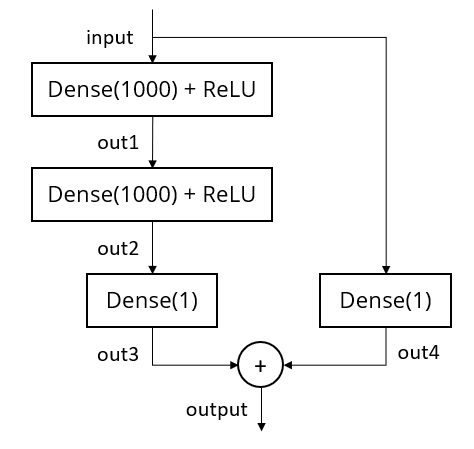

```py
input_layer = keras.Input(shape=(50,))
out1 = layers.Dense(1000, 'relu')(input_layer)
out2 = layers.Dense(1000, 'relu')(out1)
out3 = layers.Dense(1)(out2)
out4 = layers.Dense(1)(input_layer)
output = out3 + out4
model = Model(inputs=input_layer, outputs=output)
```

В предпоследней строке мы складываем друг с другом два промежуточных выхода модели (два объекта `KerasTensor`). Важно понимать, что с точки зрения языка *Python* в данном коде используется перегрузка операторов, например `out3 + out4` вызывает `out3.__add__(out4)`. За счёт этого мы можем складывать тензоры как числа. Также можно использовать следующий синтаксис: `tf.math.add(out3, out4)` или `layers.Add()([out3, out4])`. Результат во всех случаях будет эквивалентен.

У модели может быть несколько входов или выходов. Например, если мы хотим, чтобы модель возвращала не только `output`, но и `out3`, мы создадим её таким образом:

```py
model = Model(inputs=input_layer, outputs=[output, out3])
```

Одна из известных свёрточных архитектур называется **DenseNet**. Она состоит из блоков, в которых каждый слой связан со всеми последующими.

Попробуем построить её аналог, но в нашем случае слои будут полносвязными. Архитектура сети показана на иллюстрации ниже.

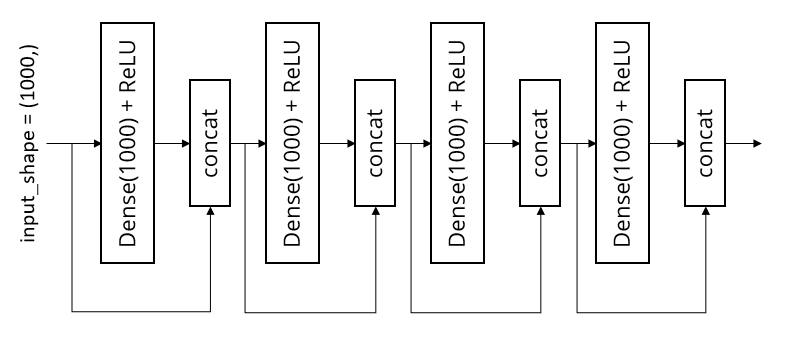

Операция `concat` означает конкатенацию и выполняется с помощью слоя `layers.Concatenate()`

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            


                                                                                                  
 dense (Dense)               (None, 1000)                 1001000   ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 2000)                 0         ['input_1[0][0]',             
                                                                     'dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 1000)                 2001000   ['concatenate[0][0]']         
                                                                                                  
 concatenate_1 (Concatenate  (None, 3000)                 0         ['concatenate[0][0]',         
 )                                                                   'dense_1[0][0]']             
          

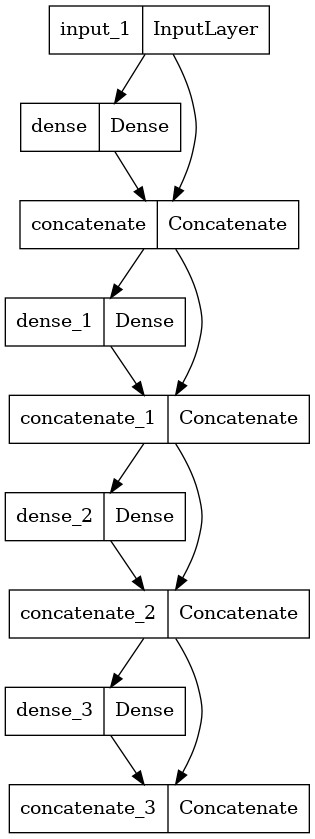

In [10]:
input_layer = keras.Input(shape=(1000,))
output = input_layer
for _ in range(4):
    output = keras.layers.Concatenate()([output, keras.layers.Dense(1000, 'relu')(output)])
model = keras.Model(inputs=input_layer, outputs=output)
model.summary()
keras.utils.plot_model(model)

### ПОСТРОЕНИЕ МОДЕЛИ В КОМБИНИРОВАННОМ СТИЛЕ

Если ветвления требуют от нас использовать функциональный стиль, то это не означает, что всю модель нужно строить в функциональном стиле. Можно использовать комбинированный подход:

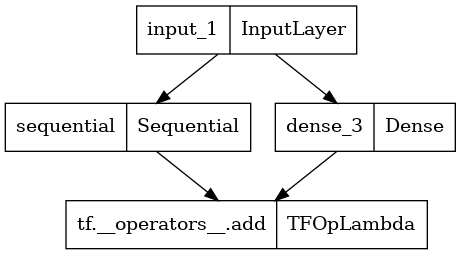

In [12]:
input_layer = keras.Input(shape=(50,))
branch1 = keras.Sequential([
    keras.layers.Dense(1000, 'relu'),
    keras.layers.Dense(1000, 'relu'),
    keras.layers.Dense(1)
])
branch2 = keras.layers.Dense(1)
output = branch1(input_layer) + branch2(input_layer)
model = keras.Model(inputs=input_layer, outputs=output)
keras.utils.plot_model(model)

### ИЕРАРХИЧЕСКИЕ МОДЕЛИ

Класс `Model` является подклассом класса `Layer`, то есть каждая модель является слоем. Это означает, что модель можно использовать в качестве слоя другой модели.

Например, в модуле `keras.applications` есть сеть `Xception`. Это свёрточная сеть довольно сложной архитектуры, построенная в функциональном стиле.

Сеть `Xception` является моделью, но её можно использовать в качестве слоя другой модели, например таким образом:

```py
from tensorflow.keras.applications import Xception
model = Sequential([
    Xception(include_top=False, input_shape=(150, 150, 3)),
    layers.GlobalMaxPool2D(),
    layers.Dropout(0.5),
    layers.Dense(10)
])
```

У получившейся модели четыре слоя, а у её первого слоя (сети `Xception`) 132 слоя:

```py
print(len(model.layers)) #4
print(len(model.layers[0].layers)) #132
```

Для сравнения — мы могли бы построить ту же самую модель таким образом:
```py
base_model = Xception(include_top=False, input_shape=(150, 150, 3))
output = layers.GlobalMaxPool2D()(base_model.output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(10)(output)
model = Model(inputs=base_model.input, outputs=output)
```

В этом случае `Xception` уже не будет вложенной моделью, все слои `Xception` станут слоями `model`. У модели `model` будет 135 слоёв.

Один и тот же слой может принадлежать нескольким моделям. Например, пусть у нас есть модель из трёх полносвязных слоёв:

```py
model = Sequential([
    layers.InputLayer(400),
    layers.Dense(300),
    layers.Dense(200),
    layers.Dense(100),
])
```

Если мы хотим получить выходное значение второго слоя модели, то можно запустить по очереди первый и второй слои:

```py
input_data = np.zeros((64, 400))
l1, l2, l3 = model.layers
layer2_output = l2(l1(input_data)).numpy()
```

Но есть и другой способ: создать ещё одну модель, входом которой является вход исходной модели, а выходом — выход второго слоя исходной модели. Это не приведёт к копированию слоёв или весов, новая модель будет использовать слои и веса старой модели.

```py
submodel = Model(inputs=model.input, outputs=model.layers[1].output)
layer2_output = submodel(input_data).numpy()
```

В данном случае модель `model` является графом вычислений, а модель `submodel` является подграфом этого графа.

### СОХРАНЕНИЕ И ЗАГРУЗКА МОДЕЛЕЙ

Можно сохранить и загрузить модель из файла следующим кодом:

```py
model.save('model.h5') #сохранение
model = keras.models.load_model('model.h5') #загрузка
```
Можно также загрузить в уже созданную модель веса из файла (`model.load_weights`), но обычно это не требуется. Расширения `.h5` и `.hdf5` эквивалентны и означают один и тот же формат файла — *Hierarchical Data Format* версии 5.



## <center>Слои и их параметры в Keras

Модуль `keras.layers` содержит большое количество разнообразных слоёв, из которых строятся нейронные сети. В этом разделе мы изучим **полносвязные слои**, **функции активации**, **считывание и изменение весов слоя**, а также кратко рассмотрим, **как выполнять произвольные операции в графе**.

Так же, как и модель, слой можно запустить как функцию, передав батч входных данных и получив результат. Если модель состоит из цепочки последовательно соединённых слоёв, то, запустив по очереди каждый слой, получим тот же результат, как если бы запустили модель целиком.

### СЧИТЫВАНИЕ И ИЗМЕНЕНИЕ ВЕСОВ СЛОЯ

Веса слоя могут быть получены в виде *NumPy*-массива методом .`get_weights()`. Например, полносвязный слой размером *N* нейронов с `input_shape=(M,)` вернёт пару из матрицы весов размером *(M, N)* и матрицы байасов размером *(N,)*.

Вручную изменить веса слоя можно методом .set_weights(). Этот метод принимает данные в том же формате, в каком возвращает их метод .get_weights(). Например, таким образом можно обнулить байасы полносвязного слоя с индексом 0:

Вручную изменить веса слоя можно методом `.set_weights()`. Этот метод принимает данные в том же формате, в каком возвращает их метод `.get_weights()`. Например, таким образом можно обнулить байасы полносвязного слоя с индексом 0:

```py
layer = model.layers[0]
W, b = layer.get_weights()
layer.set_weights((W, np.zeros_like(b)))
```

Если вызвать функцию `.get_weights()` для модели (а не для слоя), то функция вернёт кортеж (`tuple`) из всех весов модели. Например, если модель состоит из трёх полносвязных слоёв, то функция `.get_weights()` вернёт кортеж из шести массивов: *W1, b1, W2, b2, W3, b3*.

При создании слоя не в составе модели веса слоя не будут созданы. Параметр `input_shape` будет проигнорирован. Для создания весов нужно один раз запустить слой, передав в него входные данные, либо вызвать метод `.build(input_shape)`:

```py
layer = layers.Dense(100)
print([x.shape for x in layer.get_weights()])
layer.build((20,)) #или так: layer(np.zeros((1, 20)))
print([x.shape for x in layer.get_weights()])
```

Выход:

```py
[]
[(20, 100), (100,)]
```

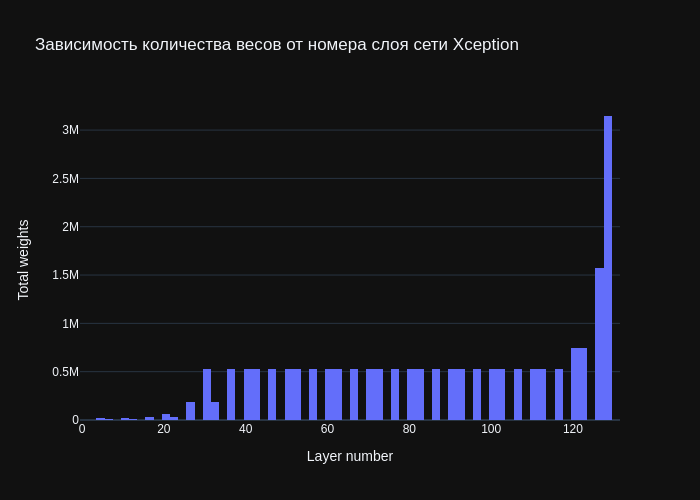

In [47]:
from keras.applications import Xception
import numpy as np
import plotly.express as px
model = Xception(include_top=False, input_shape=(150, 150, 3))
weights_dict = {}
for idx, layer in enumerate(model.layers):
    for W in layer.get_weights():
        weights_dict[idx] = np.prod(W.shape)
px.histogram(
    x=weights_dict.keys(),
    y=weights_dict.values(),
    nbins=120,
    template='plotly_dark',
    width=700,
    height=500,
    title='Зависимость количества весов от номера слоя сети Xception'
).update_xaxes(
    title='Layer number'
).update_yaxes(
    title='Total weights'
).show('png')

Колебания количества весов (вид графика в виде «расчёски») обусловлены тем, что в некоторых слоях весов вообще нет, например в слое `Activation` и `MaxPooling2D`.

### ФУНКЦИИ АКТИВАЦИИ В KERAS

```py
layers.Dense(1000, activation='relu')
```
Если мы не указываем параметр `activation`, то получим линейный слой без функции активации. Функцию активации можно указать в виде отдельного слоя.

Рассмотрим несколько примеров кода.

```py
layers.Dense(1000),
layers.Activation('relu')
```

В этом примере мы создаём полносвязный слой без функции активации, а затем функцию активации как отдельный слой. 

Для некоторых часто используемых функций активации, например *ReLU* или *Softmax*, в *Keras* существуют собственные классы:

```py
model = Sequential([
    layers.Dense(100),
    layers.ReLU(),
    layers.Dense(10),
    layers.Softmax()
])
```

Когда мы использовали слой `Activation` или параметр `activation` в слое `Dense`, мы передавали в него название функции активации в виде строки. В этом случае *Keras* ищет функцию активации с данным названием, для чего неявно вызывается следующий метод:

```py
keras.activations.get('relu')
```

Данный метод ищет функцию активации по названию и возвращает её в виде функции. Мы можем сразу указать её не в виде строки, а в виде функции:

```py
layers.Dense(1000, activation=keras.activations.relu)
```

Библиотека *Keras* изначально поддерживала разные вычислительные бэкенды. Сейчас она поддерживает только *TensorFlow*, и поэтому вместо функции-обёртки из модуля `keras.activations` мы можем сразу указывать нужную нам операцию в *TensorFlow*:

```py
layers.Dense(1000, activation=tf.nn.relu)
```

Здесь начинает проявляться гибкость в построении моделей на *Keras*. Вместо `tf.nn.relu` мы можем выполнить вообще любую операцию. Представим, что в одной из недавних статьей авторы предлагают использовать функцию активации $f(x)=\sin(x)+x$ и бьют с этой функцией рекорды точности. Мы можем легко реализовать эту функцию в нашей модели:

```py
my_activation = lambda x: tf.math.sin(x) + x
l = layers.Dense(1000, activation=my_activation)
```

### ПОЛНОСВЯЗНЫЙ СЛОЙ В KERAS

Полносвязный слой `Dense` принимает на вход массив данных с **двумя осями**: первая ось отвечает за **номер примера в батче**, вторая ось — за **номер входного признака**. Возвращает слой также массив с двумя осями, но теперь вторая ось отвечает за **номер выходного нейрона**.

Строго говоря, слой `Dense` может принимать и массив данных с большим количеством осей, но это работает неочевидным образом и **не рекомендуется к использованию**.

Давайте изучим остальные параметры, доступные в конструкторе полносвязного слоя.

```py
use_bias=True #Boolean, whether the layer uses a bias vector.
```

Если выберем значение `False`, слой не будет выполнять сложение, а будет выполнять только матричное умножение и (опционально) функцию активации.

```py
kernel_initializer="glorot_uniform" #Initializer for the kernel weights matrix.
bias_initializer="zeros" #Initializer for the bias vector.
```

Матрица весов инициализируется способом **glorot uniform** (или **xavier uniform**, что то же самое), а вектор байасов инициализируется нулями. Здесь работает тот же принцип, что описан выше для функций активации: если нечто указано в виде строки, то идёт поиск класса по названию. Например, строка `"glorot_uniform"` соответствует классу `keras.initializers.GlorotUniform`. Подробнее про инициализацию весов можно прочитать на странице документации.

Инициализация весов слоя каждый раз происходит случайным образом. Создав одинаковую модель дважды, мы получим две модели с разными начальными весами.

Если хочется достичь воспроизводимости результатов, перед созданием модели можно зафиксировать зерно случайного генератора:

`tf.random.set_seed(0)`

Есть и ещё одна тонкость: при обучении свёрточных сетей на *GPU* процесс обучения идёт **недетерминированно**, поэтому даже две сети с одинаковыми начальными весами после обучения станут разными.

Остальные параметры полносвязного слоя:

```py
kernel_regularizer=None,
bias_regularizer=None,
activity_regularizer=None,
kernel_constraint=None,
bias_constraint=None
```

С помощью этих параметров можно указать способ регуляризации весов и ограничения, накладываемые на веса. Мы сейчас не будем углубляться в эти темы. Эти параметры также можно задавать в виде строк или объектов.


### СЛОЙ FLATTEN

Как мы помним, полносвязный слой принимает на вход массив данных с двумя осями, то есть каждому примеру в батче соответствует вектор признаков.

Что делать, если на входе у нас изображение, которое имеет две оси (чёрно-белое) или три оси (цветное), а мы хотим использовать для его обработки полносвязный слой?

В этом случае нам нужно сначала применить слой `Flatten()`.

Слой `Flatten()` не имеет весов и «вытягивает в вектор» массив данных по каждому обучающему примеру, давая на выходе массив с двумя осями. Посмотрим, как эта операция выглядела бы на *NumPy*:

```py
input_shape = np.zeros((64, 256, 256, 3))
output = input_shape.reshape(len(input_shape), -1)
output.shape #(64, 196608)
```

А вот как функционирует модель с этим слоем:

In [51]:
from keras import Sequential, layers
model = Sequential([
    layers.Flatten(),
    layers.Dense(100, 'relu'),
    layers.Dense(10, 'softmax')
])
 
input_shape = np.zeros((64, 256, 256, 3))
model(input_shape).shape #(64, 10)

2023-12-19 21:03:57.470035: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


TensorShape([64, 10])

In [68]:
W, b = model.layers[1].get_weights()
total_weights = tf.reduce_sum([tf.reduce_prod(W.shape), b.shape[0]]).numpy()
print('Total weights for 1-st hidden layer:', total_weights)

Total weights for 1-st hidden layer: 19660900


На практике, если входные данные имеют больше двух осей, то, как правило, это либо изображение, либо некая последовательность, например векторизованный текст. В обоих случаях используются специальные слои, которые не требуют слоя `Flatten()`. Забегая вперёд, можно сказать, что иногда слой `Flatten()` можно встретить в свёрточных сетях после последнего свёрточного слоя.

### LAMBDA-СЛОЙ

Нередко возникает необходимость встроить в граф вычислений какое-то нестандартное действие, для которого отсутствует уже готовый слой. Такие нестандартные действия бывают двух типов:

**STATELESS**

>**Stateless** — выполнение операции, которая не содержит обучаемых параметров, например прибавление единицы к каждому элементу массива.

**STATEFUL**

>**Stateful** — выполнение операции, которая использует обучаемые параметры. Например, это может быть вариация полносвязного слоя, где вместо матричного умножения выполняется скалярное произведение.

Для первого типа операций используется слой `Lambda`, для второго типа — подкласс класса `Layer`.

Слой `Lambda` принимает в качестве параметра функцию, которую нужно выполнить над входными данными. Эта функция может содержать операции *TensorFlow* (такие как `tf.nn.relu`, `tf.math.sin`, `tf.math.maximum` и многие другие) и арифметические операции. Последние по сути также являются операциями *TensorFlow*, так как используется перегрузка операторов.

Например, один из вариантов нормализации входных данных — деление значений пикселей входного изображения на 255. Это можно реализовать, добавив в начало модели следующий слой:

`layers.Lambda(lambda x: x/255)`

Хотя для данной цели в *Keras* есть и специальный слой:

`layers.Rescaling(1/255)`

### ЗАМОРОЗКА ВЕСОВ СЛОЯ И МОДЕЛИ

У слоёв и моделей есть атрибут `.trainable`, который говорит о том, будут ли веса данного слоя обучаться или будут заморожены. Если веса слоя заморожены, то оптимизатор не будет обновлять эти веса в ходе обучения. Заморозка весов может пригодиться, если мы используем уже обученную модель, дообучая только отдельные её слои.

Изменение значения атрибута `.trainable` у модели приведёт к рекурсивному изменению этого атрибута у всех её слоев и вложенных моделей.
```py
model = Sequential([
    layers.Dense(100, 'relu'),
    layers.Dense(10),
])

model.trainable = False
```

После изменения атрибута `.trainable` нужно заново скомпилировать модель, чтобы изменения вступили в силу.



## <center>Компиляция моделей в Keras
Процесс обучения модели начинается с её компиляции. При этом мы указываем функцию потерь, оптимизатор и метрики качества.

### ФУНКЦИИ ПОТЕРЬ

Имея батч предсказаний `y_pred` и батч эталонных ответов `y_true`, мы можем посчитать значения функции потерь для каждого примера в батче, сравнивая предсказания с эталонными ответами. Затем мы можем посчитать сумму или среднее значений функции потерь по всем примерам в батче, получив одно число.  Минимизация этого числа будет означать минимизацию функции потерь по каждому примеру независимо.

В Keras функции потерь доступны в виде функций или объектов. Они взаимозаменяемы, например можно использовать `keras.losses.mean_squared_error` или `keras.losses.MeanSquaredError()` — разницы не будет.

```py
batch_size = 8
y_true = np.zeros((batch_size, 10))
y_pred = np.ones((batch_size, 10))
print(keras.losses.mean_squared_error(y_true, y_pred).numpy()) # [1. 1. 1. 1. 1. 1. 1. 1.]
print(keras.losses.MeanSquaredError()(y_true, y_pred).numpy()) # 1.0
```

Как видим, во втором варианте считается среднее значение функции потерь по всему батчу, а в первом варианте возвращается значение функции потерь по каждому примеру. Если говорить ещё точнее, то в первом случае усреднение делается только по последней оси, а батч выходных данных иногда может иметь много осей (например, если выходом сети является изображение).

Таким образом, при использовании `mean_squared_error` результатом будет не один скаляр, а массив чисел.

Однако расчёт градиентов в Keras способен работать с целым массивом функций потерь, считая его сумму. Это означает, что если усреднение не было сделано при расчёте функции потерь, оно будет сделано при расчёте градиентов.

Всё это значит, что функции потерь, заданные в виде функций или объектов, **взаимозаменяемы**.

Также вспомним, что `loss` и другие параметры можно задавать в виде строк. Если в параметр `loss` передана строка, то *Keras* будет искать по названию среди известных ему `loss`.

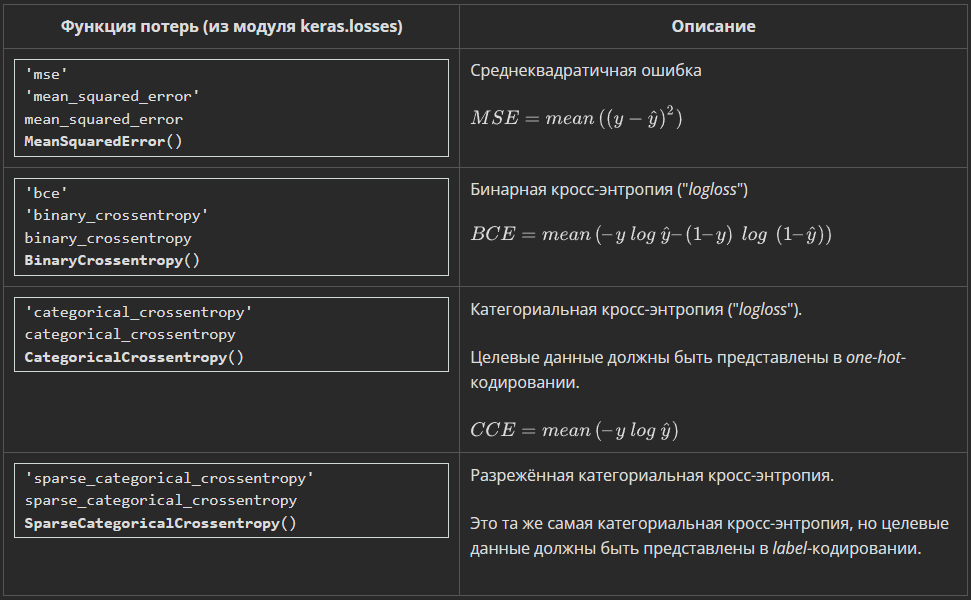

**Бинарная** кросс-энтропия используется с одним выходным нейроном и функцией активации выходного слоя `sigmoid`, **категориальная** — с несколькими выходными нейронами и функцией активации `softmax`.

В конструкторах `BinaryCrossentropy`, `CategoricalCrossentropy` и `SparseCategoricalCrossentropy` есть параметр `from_logits`, по умолчанию равный `False`. Если установить этот параметр в значение `True`, то функцию активации из выходного слоя следует убрать: она будет рассчитана внутри функции потерь.

Такой вариант предпочтительнее, поскольку он несколько стабильнее в плане погрешности вычислений. Суть в том, что `softmax` использует экспоненту, а кросс-энтропия — логарифм. Если взять экспоненту, а затем логарифм от числа, которое существенно больше/меньше нуля, то можно получить плюс или минус бесконечность из-за погрешности вычислений. Параметр `from_logits=True` и отсутствие `softmax` в выходном слое избавляют от этой проблемы.

### МЕТРИКИ КАЧЕСТВА

Любую функцию потерь можно использовать в качестве метрики. Однако не любая метрика подойдёт в качестве функции потерь: для этого она должна быть дифференцируемой.

```py
model.compile(loss=..., optimizer=..., metrics=['accuracy', ...])
```

Метрики в Keras работают неочевидным образом. В отличие от `loss`, метрики обладают накопительным действием, то есть возвращают среднее значение по всем измерениям:

```py
from keras.metrics import Accuracy
acc = Accuracy()
print(acc([0], [1]).numpy()) #0.0
print(acc([1], [1]).numpy()) #0.5
print(acc([1], [1]).numpy()) #0.6666667
```

## ОПТИМИЗАТОРЫ
Оптимизатор также является объектом. Самым распространённым оптимизатором является **Adam (Adaptive moment estimation)**. 

```py
model.compile(loss=..., optimizer='adam')
model.compile(loss=..., optimizer=keras.optimizers.Adam(1e-3))
```

Второй способ (указание оптимизатора в виде объекта, а не строки) является более гибким, так как он позволяет указывать параметры оптимизатора, в первую очередь `learning rate`. В качестве `learning rate` можно указать не только число, но и объект, описывающий стратегию его изменения со временем:

```py
from tensorflow.keras.optimizers.schedules import *
lr = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(lr)
```

`ExponentialDecay` описывает экспоненциальное затухание `learning rate`. Здесь следует внимательно подбирать параметры: слишком быстрое затухание может не дать сети успеть обучиться, а слишком медленное просто не иметь эффекта при небольшом количестве эпох.

Вместо экспоненциального затухания можно использовать полиномиальное, ступенчатое или собственную стратегию управления `learning rate`.

Есть ещё один способ управления `learning rate` — с помощью `callback`. *Learning rate* будет понижаться в те моменты, когда метрика качества на валидации перестаёт расти.

### ЧТО ПРОИСХОДИТ ПРИ КОМПИЛЯЦИИ?

При компиляции модели задаются функция потерь, оптимизатор и метрики — больше никаких действий не происходит.

Перекомпиляция модели заново требуется в случае, если вы изменили набор обучаемых весов (параметр `.trainable` у слоёв модели). В этом случае состояние оптимизатора (накопленные моменты в случае градиентного спуска с моментом) будет утеряно.



## <center>Обучение моделей в Keras

Наконец мы добрались до обучения моделей. Keras следует концепции «от простого к сложному». В простом случае обучение можно выполнить, просто вызвав метод `.fit()` на обучающих данных. Если вы хотите встроить в процесс обучения дополнительные действия, можно использовать `callback`. Если же вам нужен полный контроль над процессом обучения, вы можете написать кастомный цикл обучения

```py
model = Sequential([
    layers.InputLayer(28*28),
    layers.Dense(500, 'relu'),
    layers.Dense(500, 'relu'),
    layers.Dense(10)
])
```

Наша модель не имеет *softmax* в выходном слое, в этом случае выходные значения называют **logits**. После применения *softmax logits* превращаются в вероятности (**probabilities**).

```py
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics='accuracy'
)
 
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=1024
)
```

```
Epoch 1/10
59/59 [==============================] - 1s 10ms/step - loss: 0.4663 - accuracy: 0.8730 - val_loss: 0.1978 - val_accuracy: 0.9420
......
Epoch 10/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 0.0662 - val_accuracy: 0.9809

```

Как видим, каждая эпоха занимает 59 шагов — это размер обучающего датасета (60 000), делённый на размер батча (1024). После каждой эпохи выдаётся значение функции потерь и метрики accuracy на обучающих и валидационных данных.

### FIT, PREDICT И EVALUATE

Рассмотрим три основных метода для работы с моделями:

1. Метод `.fit()` обучает модель на данных. Если указан параметр `validation_data` или `validation_split`, то после каждой эпохи осуществляется валидация.

2. Метод `.predict()` возвращает предсказания модели на данных. В качестве альтернативы может вызывать модель как функцию, но тогда данные придётся вручную делить на батчи.

3. Метод `.evaluate()` оценивает качество модели (*loss* и метрики) на данных.

Все три метода могут принимать в качестве данных либо массивы, либо итерируемые объекты, которые генерируют батчи обучающих данных.

В *Python* итерируемым объектом называется объект, который может вернуть некую последовательность элементов.

У итерируемых объектов есть метод `obj.__iter__()`, который также может быть вызван функцией `iter(obj)`. Этот метод возвращает итератор. Итератор хранит указатель на текущий элемент и имеет метод `iter.__next__()`, который также может быть вызван функцией `next(iter)`. Этот метод как раз и возвращает следующий элемент.

Одним из важных параметров в методе `.fit()` является параметр `callbacks`.

### CALLBACKS

Параметр `callbacks` в методе `fit()` означает задание неких действий, которые будут выполнены после каждой эпохи или шага обучения.

```py
from tensorflow.keras.callbacks import *
ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
```

Этот `callback` сохраняет модель в файл `best_model.h5` (в текущей рабочей директории) в том случае, если значение `val_accuracy` после текущей эпохи достигло максимума. Например, после первых пяти эпох точность росла, а в течение следующих пяти эпох — падала. Загрузив модель из файла `best_model.h5`, вы вернёте состояние модели после первых пяти эпох, когда точность стала максимальной.

```py
EarlyStopping(monitor='val_loss', patience=5)
```

Обучение модели прекращается, если `val_loss` не падает в течение пяти эпох. Это может говорить о переобучении или стагнации процесса обучения.

1. `TerminateOnNaN()`

    Обучение прекращается, если `loss` стал равным `NaN`. Это может происходить по многим разным причинам. Среди самых очевидных:

    * слишком высокий `learning rate`;
    * отсутствие нормализации входных данных;
    * `NaN` во входных данных;
    * ошибки в архитектуре сети.

2. ```py
    LambdaCallback(on_epoch_end=lambda epoch, logs:
    print(f'Epoch {epoch} ended... Should we do something?'))
    ```

    Эта функция позволяет выполнять любые действия после конца эпохи или шага обучения (батча), а также и в другие моменты.

Если требуется выполнять какие-то действия после каждой эпохи (например, визуализация процесса обучения на графиках, получение предсказаний или изменение обучающих данных), то можно сделать цикл, в котором будет вызываться метод `.fit()` с параметром `epochs=1`, а затем будут выполняться остальные необходимые действия. Это удобнее, чем использовать `LambdaCallback`.

3. `ReduceLROnPlateau()`

    Эта функция уменьшает `learning rate` в те моменты, когда начинает наблюдаться стагнация процесса обучения, то есть выбранная метрика (по умолчанию `val_loss`) не улучшается в течение нескольких эпох. Этот `callback` является хорошей альтернативой плавному уменьшению `learning rate` от шага к шагу обучения (например `ExponentialDecay`).



## <center>Визуализация обучения в Keras

### ГДЕ ХРАНИТСЯ ИСТОРИЯ LOSS И МЕТРИК?

Объект `keras.callbacks.History()` хранит историю `loss` и метрик после каждой эпохи.

Если в списке коллбэков, переданных в метод `.fit()`, не было объекта `History`, то этот объект автоматически туда добавляется. Этот же объект возвращается из метода `.fit()`, а также записывается в параметр `model.history`.

Объект `History` имеет поле `history`, которое является словарём:

```py
display(model.history.history)

{'accuracy': [0.871, 0.953],
 'loss': [0.471, 0.161],
 'val_accuracy': [0.944, 0.963],
 'val_loss': [0.190, 0.126]}
```

В данном словаре четыре ключа: `loss` и `accuracy` при обучении и на валидации.

Рассмотрим один важный момент. История `loss` и `accuracy` на обучающих данных усредняется по каждой эпохе. Это приводит к тому, что эти показатели оказываются хуже, чем если бы они были рассчитаны на всём обучающем датасете в конце эпохи. Поэтому при визуализации график `loss` и `accuracy` на обучающих данных полезно сдвигать влево, от конца к середине эпохи.

Часто возникает ситуация, когда требуется вызывать метод `.fit()` несколько раз. Например, если вы обучаете модель в несколько стадий или по одной эпохе. Чтобы история не стиралась каждый раз, когда вы вызываетe `.fit()`, нужно передавать в качестве коллбэка уже существующую историю:

```py
model.history = keras.callbacks.History()
for epoch in range(10):
    model.fit(..., callbacks=[model.history])
```

В данном примере в `model.history` будет накапливаться история по всем десяти эпохам.

### ВИЗУАЛИЗАЦИЯ С ПОМОЩЬЮ TENSORBOARD

>**TensorBoard** — это инструмент для анализа *ML*-моделей с интерактивным интерфейсом. *TensorBoard* доступен либо в виде веб-интерфейса (через браузер), либо в виде *IPython*-виджета (в *Python*-ноутбуках). 

*TensorBoard* работает независимо от *TensorFlow*, «каналом связи» между ними является папка с логами. *TensorFlow* пишет в неё логи, а *TensorBoard* их считывает. Такой принцип работы позволяет использовать *TensorBoard* не только с *TensorFlow*, но и с *PyTorch* и другими инструментами.

Есть несколько типов данных, которые можно визуализировать в *TensorBoard*:

1. **СКАЛЯРЫ**

    Различные метрики, которые, как правило, собираются в конце каждой эпохи. Например, функция потерь и точность на обучающих и тестовых данных.

    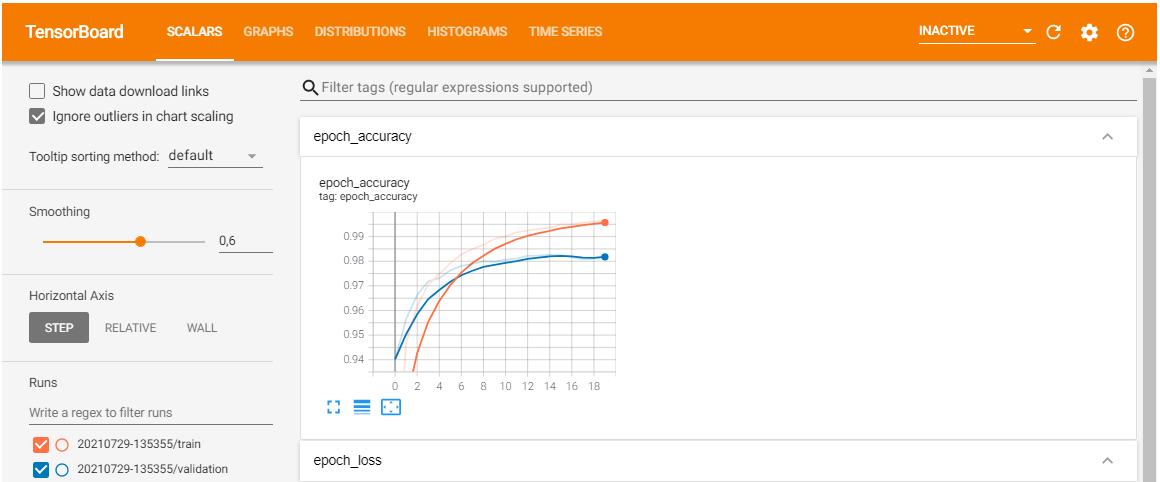

2. **ГИСТОГРАММЫ**

    На скриншоте ниже `dense_1/bias_0` означает вектор байасов первого полносвязного слоя модели. 20 гистограм соответствуют 20 эпохам обучения.

    Мы видим, как менялась гистограмма распределения байасов первого полносвязного слоя в процессе обучения.

    Рядом показаны 20 гистограмм для матрицы весов первого слоя (`dense_1/kernel_0`).

    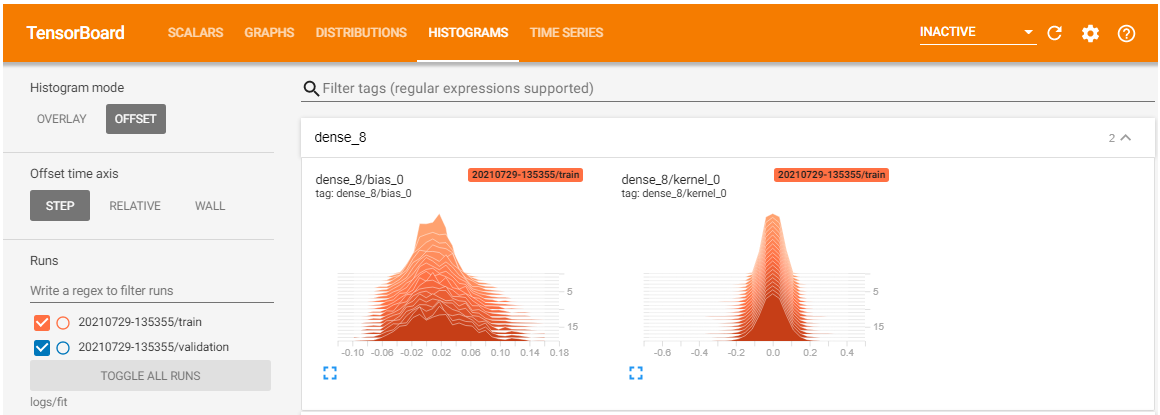

3. **ГРАФЫ ВЫЧИСЛЕНИЙ**

    Можно посмотреть, как выглядит граф вычислений целиком, включая функцию потерь и оптимизатор (в *TensorFlow* они также являются частями графа).

    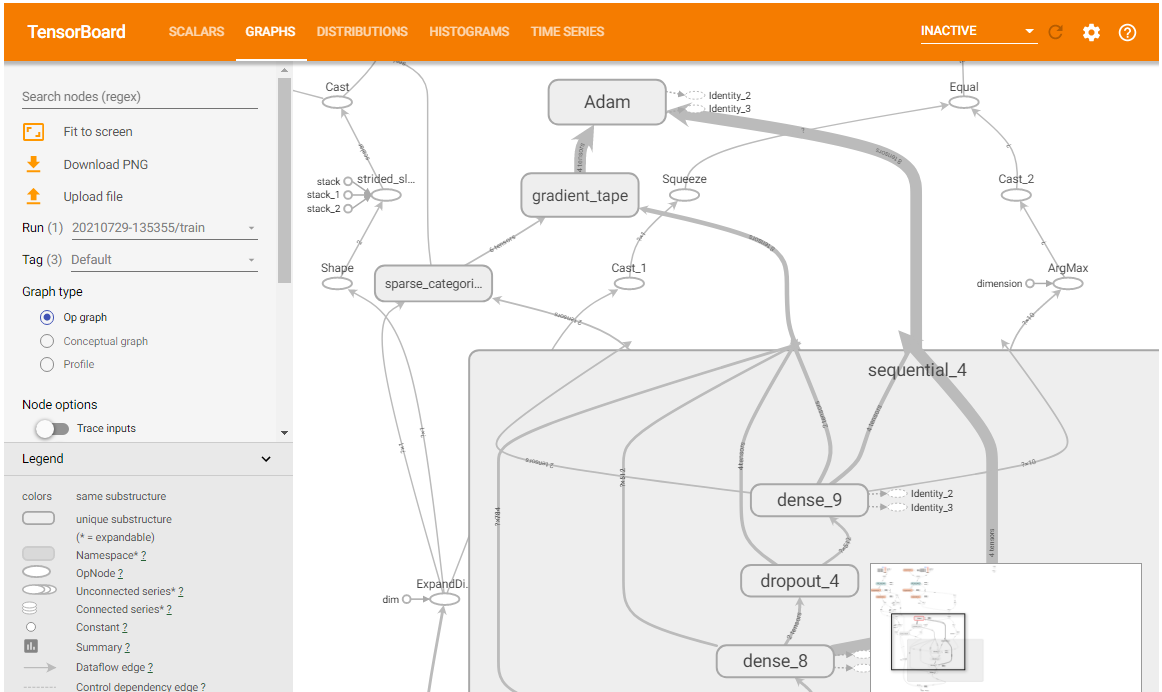

    Элементы графа можно «раскрывать» двойным щелчком, если они в свою очередь состоят из вложенных элементов. Например, так устроен полносвязный слой:

    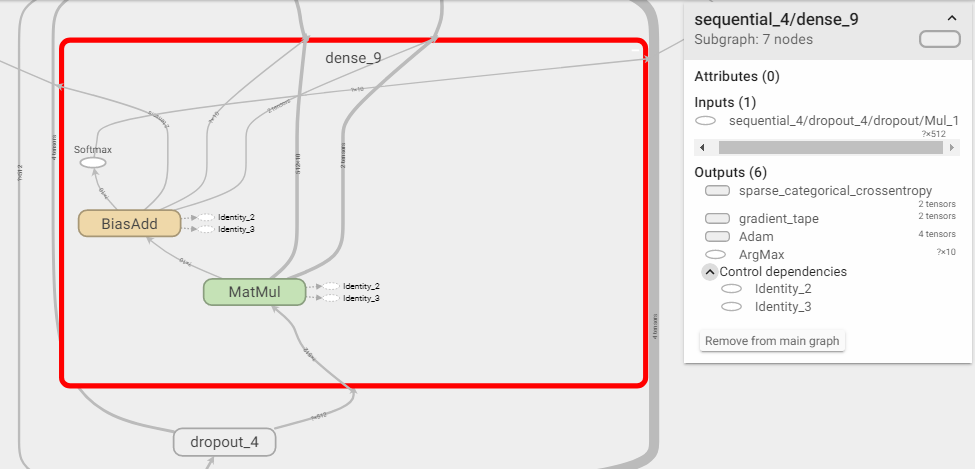

## <center>Кастомизация моделей и обучения в Keras
В компьютерном зрении стараются использовать самые новые модели и подходы, которые показывают наилучшие результаты. Для этого требуется читать научные статьи и либо искать их имплементации в виде программного кода, либо самому программировать описанные в них схемы вычислений. Часто эти схемы довольно нетривиальны.

В частности, специалисту по компьютерному зрению полезно уметь следующее:

1. «Навешивать» на модель дополнительные лоссы, то есть минимизировать одновременно несколько функций потерь (или их сумму, что то же самое).
2. Обучать параллельно на нескольких датасетах и/или несколько моделей. Типичным примером являются GAN (генеративно-состязательные сети), где две сети обучаются параллельно.
3. Следить за тем, что происходит внутри сети в процессе обучения.

### ПОСТРОЕНИЕ НЕСТАНДАРТНЫХ СЛОЁВ И МОДЕЛЕЙ

О построении нестандартных слоёв и моделей с помощью создания подклассов `Layer`, `Model` или `Sequential` можно прочитать в [официальном гайде](https://keras.io/guides/making_new_layers_and_models_via_subclassing/). 

Если мы создаём модель или слой как подкласс, то мы должны определить метод `.call()`, который преобразует входные данные в выходные. Внутри метода `.call()` мы используем последовательность операций *TensorFlow* и возвращаем результат.

По умолчанию в Keras строится статический граф вычислений. Это означает, что метод `.call()` будет вызван лишь один раз для построения статического графа, то есть для соединения операций *TensorFlow* друг с другом.

Если в методе `.call()` используются управляющие конструкции языка, такие как `if, for, while, continue, break`, то они также будут преобразованы в звенья графа, такие как `tf.cond` и `tf.while_loop`.

Иногда это может быть нежелательно, например если вы хотите использовать в методе `.call()` внешние переменные или функции из сторонних библиотек. В таком случае в метод `.compile()` необходимо передать параметр `run_eagerly=True`, и модель будет выполняться как динамический граф вычислений, то есть метод `.call()` будет вызываться каждый раз при запуске модели. Однако это может существенно повлиять на производительность.

В качестве примера давайте создадим полносвязную сеть с двумя скрытыми слоями, которые выполняются каждый раз в случайном порядке:

```py
class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.hidden_layers = [layers.Dense(784, 'relu') for _ in range(2)]
        self.head = layers.Dense(10, 'softmax')

    def call(self, input, training=None, order=None):
        output = input
        order = order or np.random.choice(range(2), 2, replace=False)
        for layer_idx in order:
            output = self.hidden_layers[layer_idx](output)
        return self.head(output)
```

Скомпилируем эту модель с параметром `run_eagerly=True` и обучим.

```py
model = CustomModel()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam', 
    metrics='accuracy',
    run_eagerly=True
)
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test),
    epochs=20,
     batch_size=1024
)
```

Теперь дважды получим предсказания: сначала запустим скрытые слои в одном порядке, затем — в обратном порядке. В каждом случае рассчитаем точность на валидации.

```py
from keras.metrics import sparse_categorical_accuracy
preds1 = model(X_test, order=[0, 1]).numpy()
preds2 = model(X_test, order=[1, 0]).numpy()
assert not np.array_equal(preds1, preds2)
print(np.mean(sparse_categorical_accuracy(y_test, preds1))) #0.9832
print(np.mean(sparse_categorical_accuracy(y_test, preds2))) #0.9817
print(np.mean(sparse_categorical_accuracy(y_test, preds1 + preds2))) #0.984
```

Этот эксперимент демонстрирует высокую способность нейронных сетей к обучению. Даже при условии, что скрытые слои выполнялись каждый раз в произвольном порядке, модель всё равно смогла обучиться и выдаёт высокую точность. Более того, из данной модели можно сделать ансамбль, запустив скрытые слои во всех возможных порядках и усреднив предсказания.

Динамический граф вычислений проще программировать, но в большинстве случаев можно построить и статический граф. Например, для придуманной нами сети, в которой скрытые слои запускаются в случайном порядке, статический граф строится следующим образом:

```py
def call_hidden_layers_in_order(self, input, order):
    output = input
    for layer_idx in order:
        output = self.hidden_layers[layer_idx](output)
    return output

def call(self, input, training=None, order=None):
    if order:
        output = self.call_hidden_layers_in_order(input, order)
    else:
        all_possible_orders = list(permutations(range(self.hidden_layers_count)))
        all_outputs_dict = {order: self.call_hidden_layers_in_order(input, order)
                            for order in all_possible_orders}
        all_outputs = tf.stack(list(all_outputs_dict.values()))
        index = tf.random.uniform((), minval=0, maxval=len(all_outputs),
                                  dtype=tf.int32)
        output = all_outputs[index]
    return self.head(output)
```

При первом взгляде на код может показаться, что мы вызываем слои во всех возможных порядках, и затем случайно выбираем один из получившихся результатов, что неэффективно с вычислительной точки зрения. Но если мы не передаём в `.compile()` параметр `run_eagerly=True`, то метод `.call()` вызывается только один раз и строит статический граф вычислений. Поэтому такой метод построения наоборот существенно ускорит обучение и инференс сети.

### КАСТОМИЗАЦИЯ ЦИКЛА ОБУЧЕНИЯ

Ранее для обучения мы всегда использовали метод .fit(), который делал за нас всю необходимую работу. Для большего контроля над тем, что происходит при обучении, мы можем написать цикл обучения вручную. Для этого нам нужно будет запускать модель, считать функцию потерь, брать откуда-то градиенты и передавать их в оптимизатор.

```py
class CustomSequential(Sequential):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

model = CustomSequential([
    layers.InputLayer(28*28),
    layers.Dense(784, 'relu'),
    layers.Dense(784, 'relu'),
    layers.Dense(10, 'softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics='accuracy')

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=1024)
```

В данном коде мы переопределяем шаг обучения для модели. Те действия, которые ранее делались автоматически, мы теперь пишем вручную. Мы получаем на вход батч данных и выполняем следующие шаги:

1. Получаем предсказания модели в режиме обучения и рассчитываем `loss`. Эти операции мы делаем в контексте объекта `tf.GradientTape()`, чтобы затем получить градиенты.

2. У каждой модели есть параметр `.trainable_variables`, в котором хранится список тензоров, являющихся обучаемыми весами модели. Мы обращаемся к этому параметру.

3. Получаем значения градиентов для тензоров `trainable_vars` из объекта `tf.GradientTape()`.

4. Передаём веса и градиенты оптимизатору, который обновляет веса, используя градиенты.

5. В последних двух строках метода `train_step` работаем с метриками.


## <center>Работа с данными в Keras. Часть I

При работе с датасетами возникают следующие технические сложности:
* Датасет часто не помещается в память целиком, поэтому его следует постепенно подгружать с диска в процессе обучения модели.

* Важно обеспечить высокую производительность процесса аугментаций и возможность распараллеливания.

* Аренда GPU cтоит денег, поэтому важно следить за загруженностью видеокарт, чтобы они не простаивали без дела. Для этого используются инструменты профилирования.

Как правило, в метод `.fit()` передаются не массивы данных (как мы делали ранее), а генераторы. В данном разделе мы сначала рассмотрим наиболее простые варианты генераторов, а затем изучим `ImageDataGenerator`. В следующем разделе мы рассмотрим наиболее продвинутый и производительный инструмент `tf.data.Dataset`.

Для полноты картины упомянем, что при работе с датасетами также возникают следующие сложности общего характера:

* Часто данные приходится собирать, очищать и размечать самостоятельно или с применением «рабочей силы», такой как Amazon Mechanical Turk.

* Датасет может быть доступен только по запросу с заполнением лицензионного соглашения. При этом ответа может не последовать либо сайт для отправки запроса может не работать.

* Из-за авторских прав набор данных может содержать не сами изображения и видео, а гиперссылки на них. Их приходится скачивать самостоятельно, причём некоторые из них могут быть уже удалены.

* Датасет может иметь неполную документацию, запутанную структуру папок, необычные форматы файлов.

### ИТЕРАТОРЫ И KERAS.UTILS.SEQUENCE

В метод `.fit()` можно передавать любой итерируемый объект, который возвращает пары из батча исходных данных и батча ответов.

Давайте повторим, что такое итераторы и генераторы в *Python*.

>**Итератор** — это объект, имеющий метод `.__next__()` для получения следующего элемента последовательности. Если элементы закончились, метод выбрасывает исключение `StopIteration`.

>**Генератор** — это функция, содержащая инструкцию `yield`. При выполнении такая функция возвращает итератор. Впрочем, на практике под «генератором» иногда понимают любой итератор, используя эти слова как синонимы.

>**Итерируемый объект (iterable-объект)** — это объект, содержимое которого можно перебрать. Такой объект должен иметь метод `.__iter__()`, возвращающий итератор, или метод `.__getitem__()`, возвращающий элемент с указанным индексом. Во втором случае объект называется **последовательностью**.

Итератор, возвращаемый методом `.__iter__()`, играет роль указателя на текущий элемент. Для итерируемого объекта можно одновременно создать несколько итераторов, они будут работать независимо.

Итераторы также являются итерируемыми объектами: их метод `.__iter__()` возвращает сам объект (`self`).

Приведём минималистичный пример, демонстрирующий использование итератора для обучения. Будем обучать модель на массиве из нулей.
```py
from tensorflow.keras import Sequential, layers
import numpy as np
 
def zeros_generator():
    while True:
        yield np.zeros((64, 100)), np.zeros((64, 10))
 
model = Sequential([layers.Dense(10)])
model.compile(loss='mse', optimizer='adam')
model.fit(zeros_generator(), steps_per_epoch=10)
```

При обучении моделей рекомендуется использовать не простые *iterable*-объекты, а последовательности, которые могут вернуть элемент по его индексу (метод `.__getitem__()`). В этом случае обучение легче распараллеливается. Последовательность можно создавать как подкласс `keras.utils.Sequence`. Этот класс «заранее» не имеет никакой функциональности — всю функциональность вы пишете сами.

### IMAGEDATAGENERATOR

Данный класс предназначен для загрузки изображений (с диска или из *NumPy*-массива), аугментаций и объединения в батчи.

Загрузим датасет *beans*, содержащий три класса изображений листьев бобов. Один класс соответствует здоровым листьям (`healthy`), два других класса — больным (`angular_leaf_spot` и `bean_rust`).

```Python
!mkdir beans_dataset
%cd beans_dataset
!wget -q https://storage.googleapis.com/ibeans/train.zip
!wget -q https://storage.googleapis.com/ibeans/validation.zip
!wget -q https://storage.googleapis.com/ibeans/test.zip
!unzip -q train.zip && rm train.zip
!unzip -q validation.zip && rm validation.zip
!unzip -q test.zip && rm test.zip
!tree -d #требует !apt-get install tree
```
**Структура папок:**

```
.
├── test
│   ├── angular_leaf_spot
│   ├── bean_rust
│   └── healthy
├── train
│   ├── angular_leaf_spot
│   ├── bean_rust
│   └── healthy
└── validation
    ├── angular_leaf_spot
    ├── bean_rust
    └── healthy
```

В каждой из девяти папок хранятся изображения.

С помощью кода ниже мы создаём объект `train_generator`, который можно использовать в методе `.fit()`.
```py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
    #rescale=1/255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)
 
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)
```

Создавая объект `ImageDataGenerator`, мы указываем необходимые преобразования, которые следует провести с каждым изображением. В первую очередь это аугментации. Затем, вызывая метод `flow_from_directory` (или методы `flow`, `flow_from_dataframe` — см. [документацию](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)), мы указываем, откуда брать изображения. В результате получаем итератор.

После выполнения кода выше ни одно изображение не было считано с диска. Изображения считываются «по требованию», то есть когда мы начнём перебирать итератор.

Давайте изучим свойства **train_generator**.

Всего итератор может вернуть 1 034 изображения, объединённых в 33 батча:

```py
print(len(train_generator), train_generator.n) #33 1034
```

Именам классов (то есть именам папок на диске) были присвоены индексы:

```py
print(train_generator.class_indices)
#{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}
```

Итератор возвращает пару из исходных и целевых данных: 32 изображения размером 128x128 с тремя цветовыми каналами (RGB) и метки классов в *one-hot*-кодировании:
```py
X, y = next(train_generator)
print(X.shape, y.shape) #(32, 128, 128, 3) (32, 3)
```

Команда `.reset()` позволяет вернуться к началу и перебирать изображения заново:
```py
print(train_generator.batch_index) #1
train_generator.reset()
print(train_generator.batch_index) #0
```

После завершения перебора итератор вернётся к началу автоматически, то есть исключение `StopIteration` никогда не будет выброшено. Поэтому в методе `.fit()` нам нужно указать параметр `steps_per_epoch`.

```py
model.fit(
    train_generator, 
    steps_per_epoch=len(train_generator), 
    epochs=20
)
```

Если мы выполняем аугментации, всегда следует проверять визуально, что в итоге получается, чтобы избежать ошибок.

### ИСПОЛЬЗОВАНИЕ ALBUMENTATIONS С IMAGEDATAGENERATOR

Ранее вы уже познакомились с библиотекой `albumentations`. Встроить её в `ImageDataGenerator` можно с помощью указания параметра `preprocessing_function`:

```py
import albumentations as A

def augment(image):
    image = image.astype(np.uint8)
    aug = A.Compose([
        A.Cutout(p=0.5, num_holes=1, max_h_size=150, max_w_size=200),
        A.Cutout(p=0.5, num_holes=1, max_h_size=100, max_w_size=150), #второй раз
        A.Cutout(p=0.5, num_holes=1, max_h_size=80, max_w_size=100), #третий раз
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.7),
        A.HueSaturationValue(p=1),
        # Читайте документацию, прежде чем копировать и использовать этот код!
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/
        # https://albumentations.ai/docs/examples/example/
        # Данный набор аугментаций — лишь пример.
        # Подумайте сами, как будет лучше, почитайте в интернете статьи по этой теме.
    ])
    return aug(image=image)['image']

my_datagen = ImageDataGenerator(
    preprocessing_function=augment
)

for _ in range(3):
    my_generator = my_datagen.flow_from_directory(
        'train',
        target_size=(384, 384),
        batch_size=4,
        shuffle=True
    )
    show_first_images(my_generator)
```

Для выполнения аугментаций не используются тензоры и операции TensorFlow. Это означает, что аугментации изображений не являются частью графа вычислений и выполняются на CPU, а не на GPU.

В этом разделе мы увидим, как сделать аугментации частью графа вычислений и выполнять их на GPU с большей производительностью.

### АУГМЕНТАЦИИ С ПОМОЩЬЮ СЛОЁВ KERAS PREPROCESSING

В данном методе аугментации (такие как поворот, отражение) являются слоями модели. Конечно, многие аугментации могут не быть дифференцируемыми, но это и не требуется. Такие слои встраиваются в начало модели и не обучаются.

```py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_generator = ImageDataGenerator().flow_from_directory(
    'train',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)
 
show_first_images(train_generator)
```

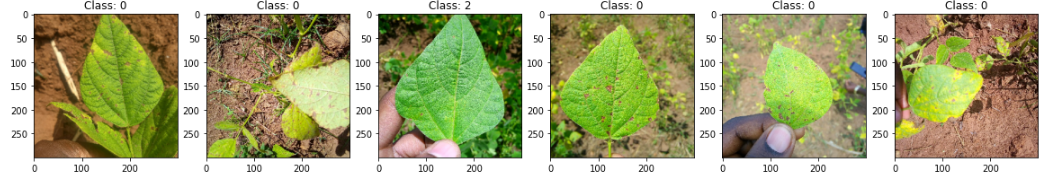

Этот генератор возвращает изображения в формате `float`, значения пикселей меняются от 0 до 255 (так как не указан параметр `rescale`), то есть изображения не нормализованы.

Аугментации можно выполнять с помощью слоёв из модуля `keras.layers.experimental.preprocessing`. Эти аугментации выполняются на GPU, что намного быстрее `albumentations`, который не использует GPU. Однако набор доступных аугментаций меньше. Для расширения набора доступных аугментаций можно использовать `tensorflow_addons`.

```PY
!pip install tensorflow_addons -q
import tensorflow_addons as tfa

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
 
preprocessing_model = Sequential([
    preprocessing.RandomCrop(200, 200),
    preprocessing.RandomFlip(mode='horizontal'),
    layers.Lambda(lambda images: tfa.image.random_cutout(images, (100, 100))),
    preprocessing.RandomRotation(0.1),
])
 
my_model = Sequential([
    preprocessing_model,
    EfficientNetB0(weights='imagenet', input_shape=(200, 200, 3), include_top=False),
    layers.GlobalMaxPool2D(),
    layers.Dropout(0.5),
    layers.Dense(10)
])
```

Слои `preprocessing` работают только в режиме обучения, тогда как слой `Lambda` работает и при обучении, и при инференсе. 

### МОДУЛЬ TF.DATA
Этот модуль представляет собой наиболее продвинутый пайплайн подготовки данных в TensorFlow.

Основным объектом, с которым мы будем работать, является `tf.data.Dataset`.

Dataset хранит информацию о конечном или бесконечном наборе элементов и может возвращать эти элементы по очереди. То есть Dataset является итерируемым объектом.

Элементом, как правило, являются входные и целевые данные для нейронной сети либо батч таких данных. Элемент — это, как правило, кортеж (в простом случае) или словарь.

Dataset позволяет выполнять с данными цепочки преобразований, которые осуществляются по мере необходимости (*lazy evaluation*).

Пока всё выглядит достаточно просто, но есть одна тонкость — **Dataset строится как статический граф вычислений**.

* С одной стороны, это является плюсом: граф компилируется и выполняется на языке C++, эффективно оптимизируется, масштабируется и распараллеливается.

* С другой стороны, в статическом графе все операции должны быть операциями TensorFlow, что усложняет работу. Если требуется применить функцию из другой библиотеки (например, из `albumentations`), то нужно «оборачивать» эту функцию в `tf.py_function`. В целом рекомендуется так не делать, а применять только операции `TensorFlow`. Например, граф с `tf.py_function` не сможет выполняться на ускорителе TPU.

`tf.data.Dataset` является статическим графом вычислений, описывающим цепочку преобразований данных перед их подачей в нейронную сеть. В графе мы применяем только операции TensorFlow.

Есть два способа создать `Dataset` из изображений, которые мы ранее загрузили в папку `beans_dataset`.

1. **Простой способ**

    ```py
    import tensorflow_datasets as tfds
    builder = tfds.ImageFolder('.')
    dataset = builder.as_dataset(split='train', shuffle_files=True)
    tfds.show_examples(dataset, builder.info, rows=1, cols=6);
    ```

    Здесь мы используем объект `ImageFolder`. Посмотрим, в каком формате датасет возвращает элементы:

    ```py
    element_dict = next(iter(dataset))
    {x: (y.shape, y.dtype) for x, y in element_dict.items()}
    ```
    Выход:
    ```py
    {'image': (TensorShape([500, 500, 3]), tf.uint8),
    'image/filename': (TensorShape([]), tf.string),
    'label': (TensorShape([]), tf.int64)}
    ```

    Элемент является словарём, содержащим изображение 500x500, имя файла и метку класса (ту же информацию можно получить, обратившись к атрибуту `dataset.element_spec`).

    Нам осталось применить аугментации, объединить изображения в батчи и обучить модель. Аугментации можно встроить в модель (как мы делали это ранее) или использовать функцию `map()`.

2. ```py
    import tensorflow as tf
    import tensorflow_addons as tfa
 
    # отбрасываем имена файлов и возвращаем кортеж (изображение, метка)
    def to_tuple(image_dict):
        return image_dict['image'], tf.one_hot(image_dict['label'], depth=3)
 
    dataset_augmented = dataset.map(to_tuple).batch(32)
 
    show_first_images(dataset_augmented.as_numpy_iterator())
    ```